## Objective
Compare RT-Sort to all other sorters 
all_sorters.ipynb-->all_sorters2.ipynb: Improved functionality by customizing for RT-Sort 

## Load sorters

In [1]:
%load_ext autoreload

In [2]:
from pathlib import Path
import pickle
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame

from tqdm import tqdm
from spikeinterface import NpzSortingExtractor

%autoreload 2
from src.sorters.base import Unit, SpikeSorter
from src import utils
from src.comparison import Comparison, DummySorter

In [3]:
TRACES_FILT_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/filt_traces.npy"  # Spikeinterface.get_traces after bandpass filter
chan_locs = utils.rec_si().get_channel_locations()
SAMP_FREQ = 30  # kHz
SORTERS_ROOT = Path("/data/MEAprojects/spikeinterface/spiketrains/mouse412804_probeC")

MATCH_SCORE = 0.5  # Minimum score needed for a match
TIME_FRAME = (5*60*1000, 10*60*1000)
"""
time_frame:
    If not None, only use coocurrences between time_frame[0]ms to time_frame[1]ms (inclusive, inclusive)
    If None, use all cooccurrences
"""

/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.6.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/pynwb/ecephys.py:93: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  "Your data may be transposed." % (self.__class__.__name__, kwargs["name"]))


Recording does not have scaled traces. Setting gain to 0.195


'\ntime_frame:\n    If not None, only use coocurrences between time_frame[0]ms to time_frame[1]ms (inclusive, inclusive)\n    If None, use all cooccurrences\n'

In [4]:
class Sorter:
    # Wrapper of NpzSortingExtractor for Comparison
    def __init__(self, full_name, name):
        self.npz = NpzSortingExtractor(SORTERS_ROOT / full_name / "sorting_cached.npz")
        self.name = name
        
    def __len__(self):
        return len(self.get_spike_times()) 
    
    def get_spike_times(self):
        start_ms, end_ms = TIME_FRAME
        
        spike_times = []
        for uid in self.npz.get_unit_ids():
            times = self.npz.get_unit_spike_train(uid) / SAMP_FREQ
            times_ind = start_ms <= times
            times_ind *= times <= end_ms
            if sum(times_ind) > 0:
                spike_times.append(times[times_ind])
        return spike_times

In [5]:
with open("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/240203/prop_signal.pickle", "rb") as f:
    RT_SORT = pickle.load(f)

In [6]:
HS = Sorter("herdingspikes", "HS")
KS = Sorter("kilosort2", "KS")
IC = Sorter("ironclust", "IC")
TDC = Sorter("tridesclous", "TDC")
SC = Sorter("spykingcircus", "SC")
HDS = Sorter("hdsort", "HDS")

SORTERS = [RT_SORT, HS, KS, IC, TDC, SC, HDS]
COMP_SORTERS = SORTERS[1:]
for sorter in SORTERS:
    print(f"{sorter.name}: {len(sorter)} units")

RT-Sort: 226 units
HS: 209 units
KS: 448 units
IC: 221 units
TDC: 187 units
SC: 616 units
HDS: 313 units


In [12]:
# Only include RT-Sort units fully above 5RMS
CHANS_RMS = utils.chans_rms_si()

above_units = []
for unit in RT_SORT:
    chans_above = unit.mean_amps >= 5 # CHANS_RMS * 5
    if np.sum(chans_above) > 0:
        above_units.append(unit)
RT_SORT.units = above_units
RT_SORT.spike_times = [unit.spike_train for unit in RT_SORT.units]
len(above_units)

139

In [ ]:
df = DataFrame(data=[len(sorter) for sorter in SORTERS], index=[sorter.name for sorter in SORTERS])
df.plot.bar(rot=0, legend=False)

plt.ylabel("Units detected")
plt.show()

In [7]:
# Set unit.chan for units in each comp sorter
tasks = []  # (sorter_idx, spike_train)
for idx, sorter in enumerate(tqdm(COMP_SORTERS)):
    for spike_train in sorter.get_spike_times():
        tasks.append((idx, spike_train))
    sorter.units = []

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:22<00:00,  3.76s/it]


In [8]:
# (continued) Set unit.chan for units in each comp sorter
def job(task, num_wfs=300, ms_before=1, ms_after=1):
    sorter_idx, entire_spike_train = task
    
    # Load outputs
    outputs = np.load(TRACES_FILT_PATH, mmap_mode="r")  # Load each time to allow for multiprocessing
    num_chans, total_num_frames = outputs.shape
    
    # Load spike train
    if num_wfs is not None and len(entire_spike_train) > num_wfs:
        np.random.seed(231)
        spike_train = np.random.choice(entire_spike_train, size=num_wfs, replace=False)
    else:
        spike_train = entire_spike_train

    # Extract waveforms
    n_before = round(ms_before * SAMP_FREQ)
    n_after = round(ms_after * SAMP_FREQ)
    templates = np.zeros((num_chans, n_before+n_after+1), dtype="float32")  # (n_chans, n_samples)
    for i, time_ms in enumerate(spike_train):
        time_frame = round(time_ms * SAMP_FREQ)
        if time_frame-n_before < 0 or time_frame+n_after+1 > total_num_frames :  # Easier and faster to ignore edge cases than to handle them
            continue
        
        window = outputs[:, time_frame-n_before:time_frame+n_after+1]
        templates += window
    templates = templates / len(spike_train)
    
    # Get channel and create Unit
    chan = np.argmin(np.min(templates, axis=1))
    unit = Unit(-1, entire_spike_train, chan, None)
    
    return sorter_idx, unit


with Pool(processes=16) as pool:
    for sorter_idx, unit in tqdm(pool.imap_unordered(job, tasks), total=len(tasks)):
        COMP_SORTERS[sorter_idx].units.append(unit)

100%|██████████| 1994/1994 [00:24<00:00, 79.80it/s]


## Compare RT-Sort to sorters
Ignore RT-Sort spikes missed by comp sorter

In [14]:
# Find which RT-Sort spikes are detected by comp sorter
def get_within_outside_spikes(sorter, comp_sorter,
                              max_ms_dist=0.4, max_micron_dist=200):
    """
    For spikes in sorter, exclude spikes that occur when no spikes from kilosort are detected
    within max_ms_dist and max_micron_dist
    
    NOTE:  prop=sorter and ks=comp_sorter
    """
    
    # Get sorted spike times and corresponding xy-positions    
    all_ks_spike_times, all_ks_spike_locs = [], []
    for unit in comp_sorter:
        all_ks_spike_times.extend(unit.spike_train)
        all_ks_spike_locs += [chan_locs[unit.chan]] * len(unit.spike_train)
    order = np.argsort(all_ks_spike_times)
    all_ks_spike_times, all_ks_spike_locs = np.array(all_ks_spike_times)[order], np.array(all_ks_spike_locs)[order]
    
    # Start loop
    # all_within_spikes = []
    # all_outside_spikes = []
    within_prop_units = []
    outside_prop_units = []
    for unit in sorter:
        loc = chan_locs[unit.chan]
        within_spikes = []
        outside_spikes = []
        for spike in unit.spike_train:
            idx = np.searchsorted(all_ks_spike_times, spike-max_ms_dist, side="left")  # Find nearest spike in all_ks_spike_times
            while idx < len(all_ks_spike_times) and np.abs(all_ks_spike_times[idx] - spike) <= max_ms_dist:
                if utils.calc_dist(*all_ks_spike_locs[idx], *loc) <= max_micron_dist:
                    within_spikes.append(spike)
                    break
                idx += 1
            else:
                outside_spikes.append(spike)

        within_prop_units.append(Unit(unit.idx, np.array(within_spikes), unit.chan, None))
        # outside_prop_units.append(Unit(unit.idx, np.array(outside_spikes), unit.chan, unit.recording))
        # all_within_spikes.append(within_spikes)
        # all_outside_spikes.append(outside_spikes)
  
    return within_prop_units # , outside_prop_units
    # return all_within_spikes, all_outside_spikes

for sorter in tqdm(COMP_SORTERS):
    sorter.within_units = get_within_outside_spikes(RT_SORT, sorter.units)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:15<00:00,  2.51s/it]


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:53<00:00,  8.91s/it]


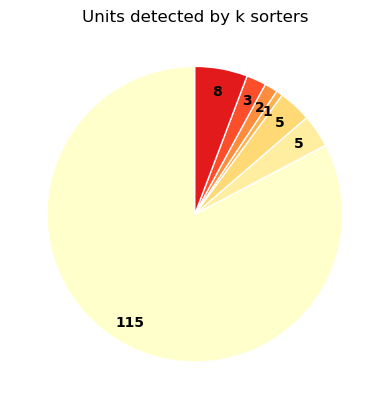

100%|██████████| 6/6 [00:53<00:00,  8.97s/it]


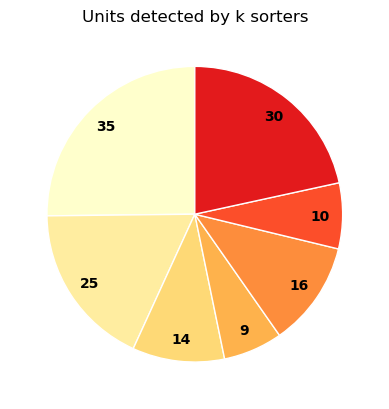

100%|██████████| 6/6 [00:53<00:00,  8.89s/it]


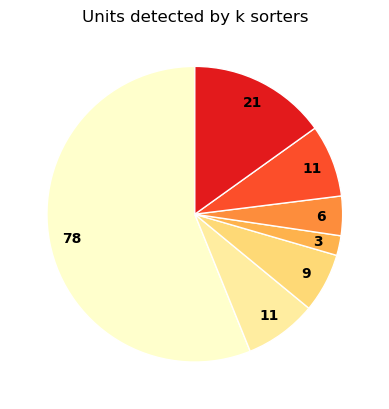

In [15]:
# Create pie charts
def plot_pie(sizes, labels):
    # Generate a list of colors for each section using 'YlOrRd' colormap
    # colors = ['#FFFFCC', '#FFEDA0', '#FED976', '#FEB24C', '#FD8D3C', '#FC4E2A']
    # colors = ['#fef2aa', '#fbdc79', '#fbb24a', "#ff8035", "#fa3e22", "#d50e24"]
    colors= ['#FFFFCC', '#FFEDA0', '#FED976', '#FEB24C', '#FD8D3C', '#FC4E2A', '#E31A1C']

    # Create the pie chart with white lines separating sections
    wedges, _ = plt.pie(sizes, colors=colors, startangle=90, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})

    # Set the title
    plt.title("Units detected by k sorters")

    # Add labels with the numbers from 'sizes' on the edges of each wedge
    for i, wedge in enumerate(wedges):
        angle = (wedge.theta2 - wedge.theta1) / 2 + wedge.theta1
        
        # Numbers outside of wedge
        # x = wedge.r * 1.1 * np.cos(angle * (3.14159 / 180))
        # y = wedge.r * 1.1 * np.sin(angle * (3.14159 / 180))
        # plt.text(x, y, str(sizes[i]), va='center', ha='center')
        
        # Numbers inside of wedge
        x = (wedge.r - 0.15) * np.cos(angle * (np.pi / 180))
        y = (wedge.r - 0.15) * np.sin(angle * (np.pi / 180))
        plt.text(x, y, str(sizes[i]), ha='center', va='center', color='black', fontweight='bold')

    # Add legend
    # plt.legend(wedges, labels, title="k=", loc='best')

    # Display the chart
    # plt.show()

for SAVE_NAME, score_formula in zip(
    ["spikeinterface_formula", "matches_divided_by_rt_sort", "matches_divided_by_other_sorter"],
    (1.5, 1, 2)):
    # One pie chart for each score formula
    all_matched_unit_ids = [unit.idx for unit in RT_SORT]  # RT-Sort detection counts a sorter detecting unit
    for comp_sorter in tqdm(COMP_SORTERS):
        
        all_spike_trains = []
        unit_ids = []
        for unit in comp_sorter.within_units:
            if len(unit.spike_train) > 0:
                all_spike_trains.append(unit.spike_train)
                unit_ids.append(unit.idx)
        rt_sort_dummy = DummySorter(all_spike_trains, "RT-Sort")
        
        comp = Comparison(rt_sort_dummy, comp_sorter, score_formula=score_formula) 
        for idx in comp.match21:
            if idx != -1:
                all_matched_unit_ids.append(unit_ids[idx])  # Need to convert from index in match to unit id
                
    _, counts = np.unique(all_matched_unit_ids, return_counts=True)
    num_sorters, counts = np.unique(counts, return_counts=True)
    plot_pie(counts, num_sorters)
    
    # import pickle
    # plt.savefig(f"/data/MEAprojects/RT-Sort/figures/230119_presentation/rt_sort_comparison/above_5rms_sequences/{SAVE_NAME}.png", format="png")
    # with open(f'/data/MEAprojects/RT-Sort/figures/230119_presentation/rt_sort_comparison/above_5rms_sequences/{SAVE_NAME}.pickle', "wb") as file:
    #     pickle.dump(plt.gcf(), file)
    plt.show()
    plt.close()